## Amazon Fine Food Review - K Means, Agglomerative, DBSCAN

### 1. Objective

                To Cluster the same type of Data points

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
import sqlite3
warnings.filterwarnings("ignore")

### 2. Data Cleaning 

In [2]:
#connecting database

con=sqlite3.connect("database.sqlite")

# Read data from database

raw_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3""",con)

# Removal of Duplicates

pre_data=raw_data.drop_duplicates(['UserId','ProfileName','Time','Text'],keep="first")

# Removal of Unconditioning data (denominator>numerator)

pre_data=pre_data[pre_data.HelpfulnessNumerator<=pre_data.HelpfulnessDenominator]


# Finding NaN values in dataframe

# Reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html

# Findind NaN values

if pre_data.isnull().values.any() == False:
    print("There is No NaN values in the DataFrame")
else:
    print(" There is NaN values present in the DataFrame")

There is No NaN values in the DataFrame


In [3]:
# sort data based on Time 

filter_data=pre_data.sort_values(by=["Time"],axis=0)

# Class Label changing
# positive class label = 1
# negative class label = 0
a=[]
for i in filter_data["Score"]:
    if i > 3:
        a.append(1)
    else:
        a.append(0)
filter_data["Score"]=a

In [4]:
filter_data.shape

(364171, 10)

In [5]:
filter_data["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

### 3. Text Preprocessing

* We took the Text column for the further review idendification task, because text is the most important feature compared to other features. 

In [7]:
# References
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
# https://stackoverflow.com/a/40823105/4084039
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
# https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number/18082370#18082370
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547#5843547
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://gist.github.com/sebleier/554280
# stemming tutorial: https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
# Lemmatisation tutorial: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
# NLTK Stemming package list: https://www.nltk.org/api/nltk.stem.html

from nltk.stem.snowball import EnglishStemmer
import re
from tqdm import tqdm
stemmer=EnglishStemmer()

In [8]:
raw_text_data=filter_data["Text"].values

In [9]:
# Stopwords

stopwords= set(['since','br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# expanding contractions

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
preprocessed_text_data=[]
for i in tqdm(raw_text_data):
# removing of HTML tags
    a=re.sub("<.*?>"," ",i)
# removing url
    b=re.sub(r"http\S+"," ",a)
# expanding contractions
    c=decontracted(b)
# removing alpha_numeric
    d=re.sub("\S*\d\S*", " ",c)
# removing Special characters
    e=re.sub('[^A-Za-z0-9]+', ' ',d)
# removing stopwords
    k=[]
    for w in e.split():
        if w.lower() not in stopwords:
            s=(stemmer.stem(w.lower())).encode('utf8')
            k.append(s)
    preprocessed_text_data.append(b' '.join(k).decode())

100%|██████████| 364171/364171 [06:59<00:00, 868.30it/s] 


In [11]:
filter_data["Text"]=preprocessed_text_data

In [12]:
filter_data.shape

(364171, 10)

### 4. K-Means Clustering

#### 4.1 Data

In [14]:
# we took the sample data size as 50k 

final_data=filter_data[:50000]
final_data.shape

(50000, 10)

In [15]:
X=final_data.Text

#### 4.2 Featurization

##### 4.2.1 Bag of Words (BoW)

In [16]:
# Reference
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

from sklearn.feature_extraction.text import CountVectorizer

In [17]:
bow_model=CountVectorizer(ngram_range=(1,2),min_df=5,max_features=500)

# BOW on data

bow_train_vec1=bow_model.fit_transform(X)

In [20]:
# the number of words in BOW or Vector size

print("The size of BOW vectorizer")
print(bow_train_vec1.get_shape()[1])

The size of BOW vectorizer
500


##### 4.2.2 TFIDF

In [21]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
tfidf_model=TfidfVectorizer(ngram_range=(1,2),min_df=5,max_features=500)

# TFIDF on data 

tfidf_train_vec1=tfidf_model.fit_transform(X)

In [23]:
# the number of words in TFDIF or Vector size

print("The size of TFIDF vectorizer")
print(tfidf_train_vec1.get_shape()[1])

The size of TFIDF vectorizer
500


##### 4.2.3 W2V

In [24]:
# References
# https://radimrehurek.com/gensim/models/word2vec.html
# https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY

from gensim.models import Word2Vec

In [25]:
list_sentences_train=[]
for i in tqdm(list(X)):
    list_sentences_train.append(i.split())

100%|██████████| 50000/50000 [00:00<00:00, 90830.71it/s]


In [26]:
word2vec_model=Word2Vec(list_sentences_train,min_count=5,size=50,workers=4)

In [27]:
word2vec_words_train=list(word2vec_model.wv.vocab)
print(" Number of words")
print("_________________")
print(" ")
print(len(word2vec_words_train))
print("="*125)
print(" sample words")
print("_________________")
print(" ")
print(word2vec_words_train[100:150])

 Number of words
_________________
 
9639
 sample words
_________________
 
['agre', 'good', 'time', 'watch', 'collect', 'fill', 'comedi', 'action', 'whatev', 'els', 'want', 'call', 'enjoy', 'entertain', 'hesit', 'pick', 'edit', 'guess', 'market', 'plan', 'famili', 'elimin', 'strong', 'element', 'usual', 'version', 'warn', 'uncut', 'avoid', 'apart', 'infest', 'fruit', 'fli', 'hour', 'trap', 'quot', 'attract', 'mani', 'within', 'practic', 'gone', 'may', 'long', 'term', 'solut', 'crazi', 'consid', 'buy', 'caution', 'surfac']


##### 4.2.4 Avg W2V

In [28]:
# Reference
# formula of Avg word2vec = sum of all (wi)[i=0 to n]/n

# avg word2vec on training data

avg_word2vec_train=[]
for i in tqdm(list_sentences_train):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_train.append(vector)  
avg_w2v_train=np.asmatrix(avg_word2vec_train)
print("shape of Avg Word2vec train")
print(avg_w2v_train.shape)

100%|██████████| 50000/50000 [00:11<00:00, 4417.53it/s]

shape of Avg Word2vec train
(50000, 50)


##### 4.2.5 TFIDF W2V

In [29]:
# References
# https://stackoverflow.com/questions/21553327
# https://github.com/devBOX03


# tfidf word2vec on training data

model=TfidfVectorizer()
tfidf_w2v_model=model.fit_transform(X)
tfidf_w2v=model.get_feature_names()
tfidf_word2vec_train=[]
row=0
for i in tqdm(list_sentences_train):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_train.append(vec)
    row=row+1
tfidf_w2v_train=np.asmatrix(tfidf_word2vec_train)
print("Shape of TFIDF word2vec train")
print(tfidf_w2v_train.shape)

100%|██████████| 50000/50000 [16:47<00:00, 49.65it/s] 

Shape of TFIDF word2vec train
(50000, 50)


#### 4.3 K-Means using BoW

In [30]:
# References 
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://imaddabbura.github.io/post/kmeans_clustering/
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
# https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob

from sklearn.cluster import KMeans

In [31]:
# Hyperparameter tuning 


k = [2,3,4,5,6,8,10]

inertias=[]

for i in tqdm(k):
    
    model = KMeans(n_clusters=i,n_jobs=-1)
    model.fit(bow_train_vec1)
    sum_sq_values = model.inertia_
    inertias.append(sum_sq_values)

100%|██████████| 7/7 [1:24:38<00:00, 811.21s/it]


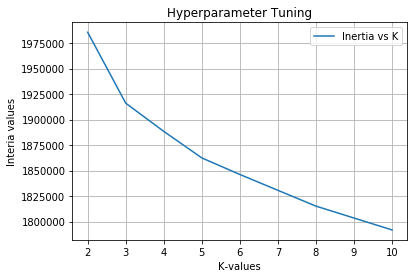

In [63]:
# plotting the k vs inertia 

plt.close()
plt.plot(k,inertias,label="Inertia vs K")
plt.grid()
plt.title("Hyperparameter Tuning")
plt.xlabel("K-values")
plt.ylabel("Interia values")
plt.legend()
plt.show()

##### Observation:

* By using the elbow method the best k (number of clusters) is 6

In [35]:
# Applying Best Hyperparameter

model= KMeans(n_clusters=6,n_jobs=-1)
model.fit(bow_train_vec1)
labels=model.labels_

##### Number Datapoints in Each Cluster

In [42]:
# Data points seperation as per the clusters

number_points = labels.shape[0]
print("Number of Datapoints")
print(number_points)

Number of Datapoints
50000


In [58]:
# Datapoints divided by clusters as per the label name

cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]
cluster_5=[]
cluster_6=[]

for i in range(0,number_points):
    
    if labels[i] == 0:
        cluster_1.append(i)
    if labels[i] == 1:
        cluster_2.append(i)
    if labels[i] == 2:
        cluster_3.append(i)
    if labels[i] == 3:
        cluster_4.append(i)
    if labels[i] == 4:
        cluster_5.append(i)
    if labels[i] == 5:
        cluster_6.append(i)

In [65]:
# References
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

In [66]:
# The number of datapoints in each cluster

a=PrettyTable()

a.field_names = ["Cluster", "Number of Data Points"]

print(" The number of datapoints in each cluster")
print("="*120)

a.add_row([1,str(len(cluster_1))])
a.add_row([2,str(len(cluster_2))])
a.add_row([3,str(len(cluster_3))])
a.add_row([4,str(len(cluster_4))])
a.add_row([5,str(len(cluster_5))])
a.add_row([6,str(len(cluster_6))])
print(a)

 The number of datapoints in each cluster
+---------+-----------------------+
| Cluster | Number of Data Points |
+---------+-----------------------+
|    1    |         11297         |
|    2    |          1216         |
|    3    |          2153         |
|    4    |          256          |
|    5    |         33657         |
|    6    |          1421         |
+---------+-----------------------+


##### Wordcloud for each cluster:

###### Cluster 1

* Getting the sample reviews in Cluster 1

In [161]:
# References
# https://www.geeksforgeeks.org/generating-word-cloud-python/

from wordcloud import WordCloud

In [168]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(11297,size=3)

In [169]:
rand_num = list(rand_num)

In [170]:
rand_num

[1061, 225, 6566]

In [171]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_1[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [172]:
string_1 = " ".join(word_cloud)

In [173]:
string_1

'love granola cereal general say best granola ever peopl bear nake philosophi love back everi bag believ food hand made wholesom natur ingredi actual pronounc although eat process food appreci appeal tradit prepar food granola top list nutrit tast like granola high calori fat take note fat come larg nut contain also contain expel press canola oil no tran fat satur fat per serv cereal softer granola though not soft enough consid chewi larg chunk nut also contain cranberri flax seed optim nutrit digest health six pack sold amazon make price per packag reason ingredi quit expens valu proposit think not great product great buy delici nutriti great combin recommend high got best hot sauc ever flavor concern buy one blair hotter sauc add bit increas sauc heat like heat level tabasco time flavor never met anyon not love sauc tri hunt decent treat gsd tplo surgeri recov nice search healthi treat came across happi hip ingredi natur absolut love idea also benefiti joint add special bonus product

In [174]:
wordcloud_1 = WordCloud(width=720, height=720, max_words=50).generate(string_1)

###### Cluster 2

* Getting the sample reviews in Cluster 2

In [177]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(1216,size=3)
rand_num = list(rand_num)

In [178]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_2[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [179]:
string_2 = " ".join(word_cloud)

In [180]:
string_2

'coffe great husband total coffe snob happi roast fresh coffe quick deliveri torani wonder italian sound although made south san francisco pretti ubiquit bay area found mani groceri store especi coffe bar cafe least good sweeten best actual impart promis flavor peppermint deliv would rank hazelnut far musti old tast almond torani peppermint add peppermint flavor get nice non alcohol addit hot chocol coffe dessert steam milk ingredi nutrit inform one ounc syrup serv ml bottl contain calori no fat gram carbohydr gram sugar no wonder sweet presenc actua peppermint slight suspect list ingredi pure cane sugar water natur flavor natur flavor sodium benzoat potassium sorbat preserv citric acid one hint close tight ant love stuff keurig coffe maker offic coupl year enjoy immens probabl tri everi offer avail offic includ regular caffein coffe far flavor emeril jazz decaf tend favor decaf one stand among one favorit offic timothi rainforest espresso good right howev ran emeril forc brew cup rain

In [181]:
wordcloud_2 = WordCloud(width=720, height=720, max_words=50).generate(string_2)

###### Cluster 3

* Getting the sample reviews in Cluster 3

In [182]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(2153,size=3)
rand_num = list(rand_num)

In [184]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_3[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [185]:
string_3 = " ".join(word_cloud)

In [186]:
string_3

'great peopl asthma like tast best result abl breath freeli releiv congest feel better inhal although let tea steep recommend minut yogi tea breath deep tea bag reorder blow first oz tin week use flavor black tea mix anoth herbal tea thing leeri becom addict adagio great tea servic receiv tea birthday gift general not like tea odd flavor not like stuff like cinnamon lemon rose hip orang rind tea love smell flavor light pleasant tea bag nice qualiti recommend tea'

In [187]:
wordcloud_3 = WordCloud(width=720, height=720, max_words=50).generate(string_3)

###### Cluster 4

* Getting the sample reviews in Cluster 4

In [196]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(256,size=3)
rand_num = list(rand_num)

In [197]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_4[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [198]:
string_4 = " ".join(word_cloud)

In [199]:
string_4

'tri tea first time tri origin chai indian spice tea yesterday fell love chai tea cannot tast differ tea origin indian spice tea cup back back sure tast exact know origin vanilla no honey not add sugar anyth els tea cannot tast honey tea excel sure cannot go wrong celesti season chai tea look differ flavor origin tri chocol enhanc tea good sweet slight milder one term indian spice black pepper flavor still wonder tea health benefit white tea black tea folk unit kingdom drink pg tip tea brand perhap tri choic way folk ireland drink tea per person countri pg tip tea pg tip special blend tea home standard tea specialti retail usa offer pg tip special blend tea hope amazon soon pre digest era histori tea introduc name pre gest tee suggest tea could consum food eaten grocer gave abbrevi pg compani ad tip compani use best part tea plant two top leav bud tea plant make tea mani black tea sold usa grade basic medium grade orang peko general tea leav top two bud one reason pg tip get higher rev

In [200]:
wordcloud_4 = WordCloud(width=720, height=720, max_words=50).generate(string_4)

###### Cluster 5

* Getting the sample reviews in Cluster 5

In [201]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(33657,size=3)
rand_num = list(rand_num)

In [202]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_5[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [203]:
string_5 = " ".join(word_cloud)

In [204]:
string_5

'buy year son daughter love quick snack high salt least nutrit no longer interest mom homecook main eat junk noth tri say chang least tri find healthiest junk food dog listen snack good given young children sort trick beg snack come folk kid perfect dog qualiti bean fantas smooth not bitter medium bold tast depend quaniti bean use good would recomend brand flavor bean buy'

In [205]:
wordcloud_5 = WordCloud(width=720, height=720, max_words=50).generate(string_5)

###### Cluster 6

* Getting the sample reviews in Cluster 6

In [206]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(1421,size=3)
rand_num = list(rand_num)

In [207]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_6[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [208]:
string_6 = " ".join(word_cloud)

In [209]:
string_6

'kraft light balsam vinaigrett extra virgin oliv oil reduc fat dress whew long name help peopl like diet tast inde bold think tast come sodium salad dress hand inde made extra virgin oliv oil wonder gram fat tablespoon serv gram gram carb per serv no artifici preserv bonus probabl even better health amazon nutrit fact would indic not think amazon got quit right quot calor content nutrit fact tabl bottl product yes match pictur exact product nutrit fact label bottl indic calori total per serv serv consist tablespoon addit nutrit fact label bottl indic amount calori come fat total calori per serv not calori amazon note would like think kraft nutrit label correct perhap amazon accident made misprint two unfortun amount sodium indic webpag accur overal great dress tast great add punch salad simpli not find salad dress fewer calori although might watch sodium issu salt free diet check nutritionist doctor first make sure dress someth enjoy salad use salad mixtur romain iceberg lettuc carrot 

In [210]:
wordcloud_6 = WordCloud(width=720, height=720, max_words=50).generate(string_6)

##### Plotting The Wordcloud 

* <b>Cluster 1<b> 

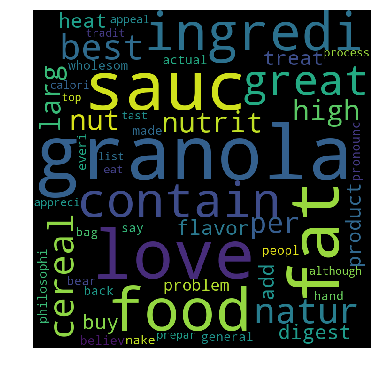

In [211]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about how the product tastes and quality

* <b>Cluster 2<b>

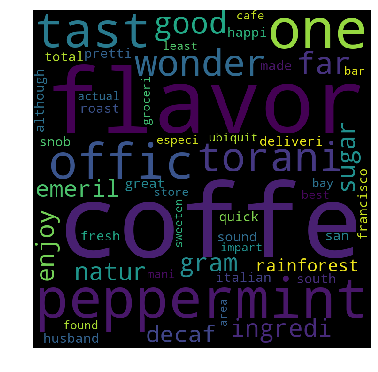

In [212]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about coffee and dairy products.

* <b>Cluster 3<b>

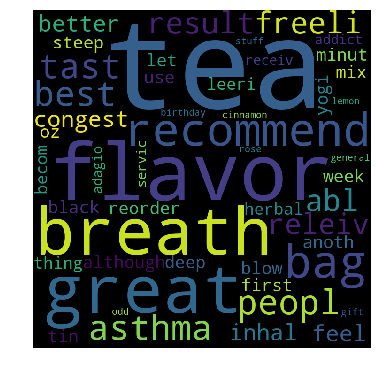

In [213]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_3) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about tea products. 

* <b>Cluster 4<b>

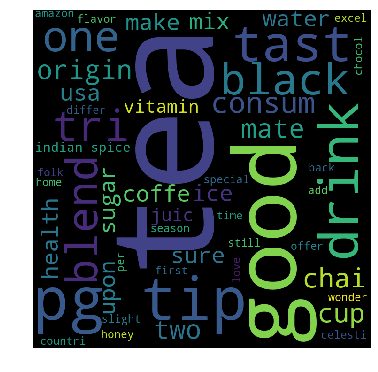

In [214]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_4) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about tea products. 

* <b>Cluster 5<b>

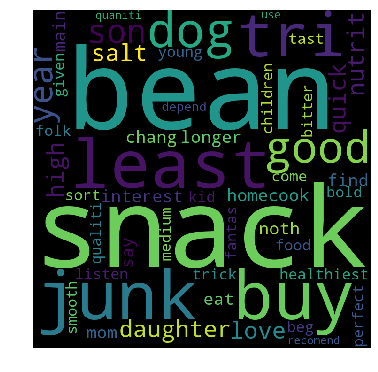

In [215]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_5) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about snack products. 

* <b>Cluster 6<b>

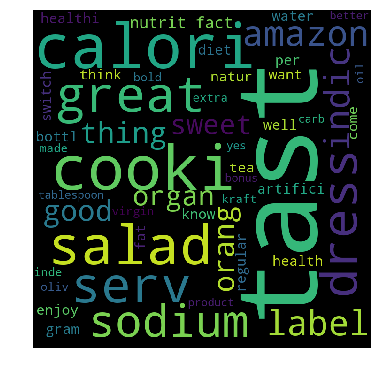

In [216]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_6) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about cookies and product quality as well as tast. 

##### Performance Metric of K means using BoW

In [233]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html

from sklearn.metrics import silhouette_score

In [234]:
score = silhouette_score(bow_train_vec1,labels)

In [235]:
score

0.1602613063543015

#### Observation:

* As per the silhouette score document if the score is nearest to the Zero. The Clusters are Overlapped. So here The Silhouette Score is 0.16. So here the chance of clusters overlapping is high.

#### 4.4 K-Means using TFIDF

In [236]:
# Hyperparameter tuning 

k = [2,3,4,5,6,8,10]

inertias=[]

for i in tqdm(k):
    
    model = KMeans(n_clusters=i,n_jobs=-1)
    model.fit(tfidf_train_vec1)
    sum_sq_values = model.inertia_
    inertias.append(sum_sq_values)


100%|██████████| 7/7 [1:42:00<00:00, 1003.11s/it]

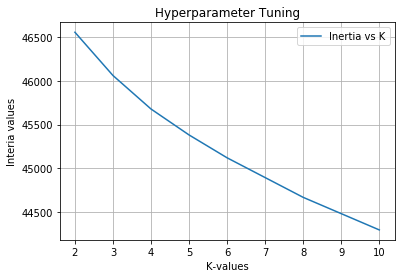

In [237]:
# plotting the k vs inertia 

plt.close()
plt.plot(k,inertias,label="Inertia vs K")
plt.grid()
plt.title("Hyperparameter Tuning")
plt.xlabel("K-values")
plt.ylabel("Interia values")
plt.legend()
plt.show()

##### Observation:

* By using the elbow method the best k (number of clusters) is 6

In [238]:
# Applying Best Hyperparameter

model= KMeans(n_clusters=6,n_jobs=-1)
model.fit(tfidf_train_vec1)
labels=model.labels_

##### Number Datapoints in Each Cluster

In [239]:
# Data points seperation as per the clusters

number_points = labels.shape[0]
print("Number of Datapoints")
print(number_points)

Number of Datapoints
50000


In [240]:
# Datapoints divided by clusters as per the label name

cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]
cluster_5=[]
cluster_6=[]

for i in range(0,number_points):
    
    if labels[i] == 0:
        cluster_1.append(i)
    if labels[i] == 1:
        cluster_2.append(i)
    if labels[i] == 2:
        cluster_3.append(i)
    if labels[i] == 3:
        cluster_4.append(i)
    if labels[i] == 4:
        cluster_5.append(i)
    if labels[i] == 5:
        cluster_6.append(i)

In [242]:
# The number of datapoints in each cluster

b=PrettyTable()

b.field_names = ["Cluster", "Number of Data Points"]

print(" The number of datapoints in each cluster")
print("="*120)

b.add_row([1,str(len(cluster_1))])
b.add_row([2,str(len(cluster_2))])
b.add_row([3,str(len(cluster_3))])
b.add_row([4,str(len(cluster_4))])
b.add_row([5,str(len(cluster_5))])
b.add_row([6,str(len(cluster_6))])
print(b)

 The number of datapoints in each cluster
+---------+-----------------------+
| Cluster | Number of Data Points |
+---------+-----------------------+
|    1    |         25081         |
|    2    |          3266         |
|    3    |          4254         |
|    4    |         10341         |
|    5    |          3041         |
|    6    |          4017         |
+---------+-----------------------+


##### Wordcloud for each cluster:

###### Cluster 1

* Getting the sample reviews in Cluster 1

In [249]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(25081,size=3)

In [250]:
rand_num = list(rand_num)

In [251]:
rand_num

[19568, 10550, 14639]

In [252]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_1[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [253]:
string_1 = " ".join(word_cloud)

In [254]:
string_1

'use decor ginger bread kid actual pick bread eat curious tri tast good liven ginger bread decor tast product high recommend better altern regular cook oil healthi good bodi use yeast bread machin bake best yeast market'

In [255]:
wordcloud_1 = WordCloud(width=720, height=720, max_words=50).generate(string_1)

###### Cluster 2

* Getting the sample reviews in Cluster 2

In [256]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(3266,size=3)
rand_num = list(rand_num)

In [257]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_2[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [258]:
string_2 = " ".join(word_cloud)

In [259]:
string_2

'four older cat one seem ill two horribl skin chang food trip vet within week skin healthi look gorgeous worth iam scienc diet cat would eat wild one cheapest peopl planet worth hard earn way cheaper trip vet truli believ food save cat life treat buy dog one crohn diseas give servic excel receiv quick not first time bought shipper not last best friend age shetland sheepdog name jake absolut love treat use get local pet store recent move not find anywher nearbi cours turn amazon happili half price ship use pay jake hip dysplasia surgeri young adult dog walk notic limp slowli becom wors shun glucosamin supplement littl help found wonder treat gait not seem degrad happi still get love littl dog piec anyth make life littl better littl longer great thing enjoy eat make godsend'

In [260]:
wordcloud_2 = WordCloud(width=720, height=720, max_words=50).generate(string_2)

###### Cluster 3

* Getting the sample reviews in Cluster 3

In [261]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(4254,size=3)
rand_num = list(rand_num)

In [262]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_3[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [263]:
string_3 = " ".join(word_cloud)

In [264]:
string_3

'tea lover not touch coffe not even mocha coffe icecream year gotten know various differ tea tea brand adagio one best brand tri price better averag tea qualiti yunnan gold adagio premium grade yunnan tea lower grade yunnan jig quit good inexpens yunnan gold fantast assert tea abl stand nice milk sugar not slightest bit bitter black still tasti prefer black tea light sweet even accident steep steep minut smooth mellow natur sweet tea complex flavor spici yet subtl fyi consid black tea black tea name base upon long allow ferment green tea least ferment oolong ferment black tea allow reach complet ferment general speak tea ferment caffien contain perfect day tea pleasur first thing morn yet delight day night caffien insomnia avoid drink caffien beverag pm like bold tea like hearti assam cylon tea might delic although still suggest give tri might seduc mani virtu ad adult children easter basket truli enjoy tast light crisp total delici plan use rest tea parti hostess gift blend littl appl

In [265]:
wordcloud_3 = WordCloud(width=720, height=720, max_words=50).generate(string_3)

###### Cluster 4

* Getting the sample reviews in Cluster 4

In [266]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(10341,size=3)
rand_num = list(rand_num)

In [267]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_4[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [268]:
string_4 = " ".join(word_cloud)

In [269]:
string_4

'favorit starbuck roast dont go local starbuck purchas price go dont pay ship handel stuff plus grind flour wet anoth product bought open spill flour salvag flour could not contact amazon problem tri follow procedur not sucess product not cheap not sure anoth order amazon add kid milk ad protein calcium clump togeth mix blender tast great worth price avoid hormon non organ milk hard find around glad amazon carri offer cheaper special order health food store add homemad ice ice cream'

In [270]:
wordcloud_4 = WordCloud(width=720, height=720, max_words=50).generate(string_4)

###### Cluster 5

* Getting the sample reviews in Cluster 5

In [271]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(3041,size=3)
rand_num = list(rand_num)

In [272]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_5[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [273]:
string_5 = " ".join(word_cloud)

In [274]:
string_5

'anoth great coffe lavazza usual use cafe espresso blend one even better finer cafe espresso crema refin tast brew daili gaggia revolut delight decaf gevalia coffe cappucino delici come perfect everi time tassimo unfortun varieti decaf coffe avail current excel come close coffe hous qualiti purchas coffe regular donat urban soup kitchen fall winter no brand found come close price especi discount whatev purchas not speak tast not coffe drinker homeless client full prais ad coffe day menu homeless indig plenti complain live yet complain coffe coffe vacuum pack realli help origin fresh open flavor get pack'

In [275]:
wordcloud_5 = WordCloud(width=720, height=720, max_words=50).generate(string_5)

###### Cluster 6

* Getting the sample reviews in Cluster 6

In [276]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(4017,size=3)
rand_num = list(rand_num)

In [277]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_6[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [278]:
string_6 = " ".join(word_cloud)

In [279]:
string_6

'would high recommend chocol marzipan hous friend famili honest best white chocol ever like white chocol tri one not good snack bitter tast not surpris though chocol bitter tast without sugar raw defin get great shake recepi flavor realli come'

In [280]:
wordcloud_6 = WordCloud(width=720, height=720, max_words=50).generate(string_6)

##### Plotting The Wordcloud 

* <b>Cluster 1<b> 

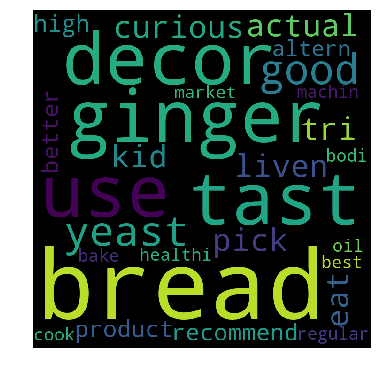

In [281]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about baked goods.

* <b>Cluster 2<b>

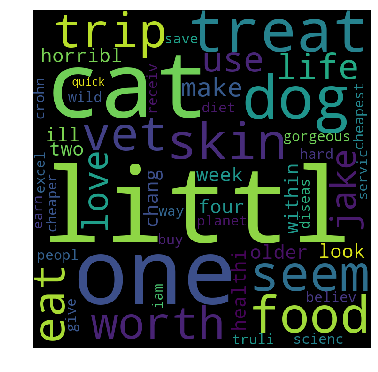

In [282]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about pet food products.

* <b>Cluster 3<b>

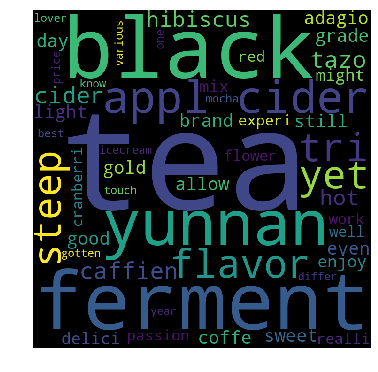

In [283]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_3) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about tea products.

* <b>Cluster 4<b>

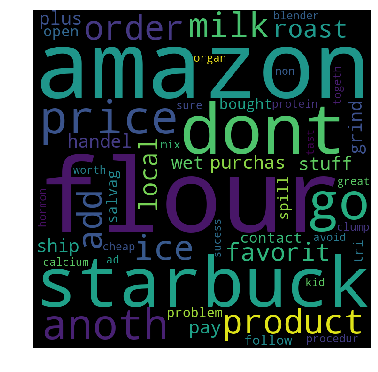

In [284]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_4) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about dairy products.

* <b>Cluster 5<b>

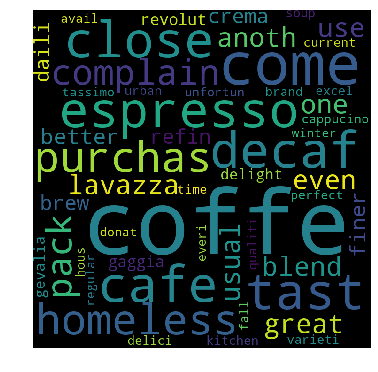

In [285]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_5) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about coffee products.

* <b>Cluster 6<b>

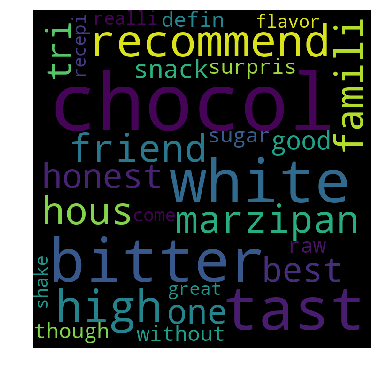

In [286]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_6) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about choco products,product quality and taste.

##### Performance Metric of K means using TFIDF

In [287]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html

from sklearn.metrics import silhouette_score

In [288]:
score = silhouette_score(tfidf_train_vec1,labels)

In [289]:
score

0.02185273520661483

#### Observation:

* As per the silhouette score document if the score is nearest to the Zero. The Clusters are Overlapped. So here The Silhouette Score is 0.02. So here the chance of clusters overlapping is high.

#### 4.5 K-Means using Avg W2V

In [290]:
# Hyperparameter tuning 

k = [2,3,4,5,6,8,10]

inertias=[]

for i in tqdm(k):
    
    model = KMeans(n_clusters=i,n_jobs=-1)
    model.fit(avg_w2v_train)
    sum_sq_values = model.inertia_
    inertias.append(sum_sq_values)


100%|██████████| 7/7 [00:21<00:00,  3.74s/it]

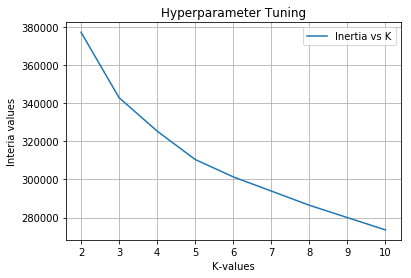

In [291]:
# plotting the k vs inertia 

plt.close()
plt.plot(k,inertias,label="Inertia vs K")
plt.grid()
plt.title("Hyperparameter Tuning")
plt.xlabel("K-values")
plt.ylabel("Interia values")
plt.legend()
plt.show()

##### Observation:

* By using the elbow method the best k (number of clusters) is 6

In [292]:
# Applying Best Hyperparameter

model= KMeans(n_clusters=6,n_jobs=-1)
model.fit(avg_w2v_train)
labels=model.labels_

##### Number Datapoints in Each Cluster

In [293]:
# Data points seperation as per the clusters

number_points = labels.shape[0]
print("Number of Datapoints")
print(number_points)

Number of Datapoints
50000


In [294]:
# Datapoints divided by clusters as per the label name

cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]
cluster_5=[]
cluster_6=[]

for i in range(0,number_points):
    
    if labels[i] == 0:
        cluster_1.append(i)
    if labels[i] == 1:
        cluster_2.append(i)
    if labels[i] == 2:
        cluster_3.append(i)
    if labels[i] == 3:
        cluster_4.append(i)
    if labels[i] == 4:
        cluster_5.append(i)
    if labels[i] == 5:
        cluster_6.append(i)

In [295]:
# The number of datapoints in each cluster

c=PrettyTable()

c.field_names = ["Cluster", "Number of Data Points"]

print(" The number of datapoints in each cluster")
print("="*120)

c.add_row([1,str(len(cluster_1))])
c.add_row([2,str(len(cluster_2))])
c.add_row([3,str(len(cluster_3))])
c.add_row([4,str(len(cluster_4))])
c.add_row([5,str(len(cluster_5))])
c.add_row([6,str(len(cluster_6))])
print(c)

 The number of datapoints in each cluster
+---------+-----------------------+
| Cluster | Number of Data Points |
+---------+-----------------------+
|    1    |          3979         |
|    2    |         11841         |
|    3    |          7379         |
|    4    |          6349         |
|    5    |         11653         |
|    6    |          8799         |
+---------+-----------------------+


##### Wordcloud for each cluster:

###### Cluster 1

* Getting the sample reviews in Cluster 1

In [296]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(3979,size=3)

In [297]:
rand_num = list(rand_num)

In [298]:
rand_num

[993, 3511, 3145]

In [299]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_1[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [300]:
string_1 = " ".join(word_cloud)

In [301]:
string_1

'system litter box clean much better scoop hand especi multipl cat howev thing not perfect clump get stuck sifter especi urin fresh end wipe anyway outsid buy electron self clean litter box not read great thing system job pretti painless dog love even goe counter stare contain time bone cat see bag come run love death one girl know age year old'

In [302]:
wordcloud_1 = WordCloud(width=720, height=720, max_words=50).generate(string_1)

###### Cluster 2

* Getting the sample reviews in Cluster 2

In [303]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(11841,size=3)
rand_num = list(rand_num)

In [304]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_2[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [305]:
string_2 = " ".join(word_cloud)

In [306]:
string_2

'search local store month find brook rich tangi ketchup final heard no longer made went internet see could find bottl anywher discov made canada also found could find websit chanc bought case share bottl famili friend rais ketchup ever put tabl make barbecu sauc give extra tang want not ketchup person want kind want eat spent first year life germani rememb first time got care packag germani gummi bear thrill noth like eat origin gummi candi second round herb kit batch purchas three kit mix pod make fall winter mix cilantro basil pars thyme savori sage oregano basil thyme savori oregano new italian herb kit everyth plant either sprout day earli right time savori appear delic bunch grown tallest three week start basil first sprout pars seem slow steadi herb good least six month proper care sure could extend life easi care great alway fresh herb dispos recom product anyon love fresh herb anyon problem grow herb past'

In [307]:
wordcloud_2 = WordCloud(width=720, height=720, max_words=50).generate(string_2)

###### Cluster 3

* Getting the sample reviews in Cluster 3

In [308]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(7379,size=3)
rand_num = list(rand_num)

In [309]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_3[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [310]:
string_3 = " ".join(word_cloud)

In [311]:
string_3

'coffe good organ better would tell tri coffe nantucket blend one favorit k cup coffe made medium blend coffe tast great flavor creamer regular creamer milk definit buy one love keurig coffe maker discov buy coffe thru amazon littl cheaper prime ship flavor like rich strong coffe hint espresso flavor'

In [312]:
wordcloud_3 = WordCloud(width=720, height=720, max_words=50).generate(string_3)

###### Cluster 4

* Getting the sample reviews in Cluster 4

In [313]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(6349,size=3)
rand_num = list(rand_num)

In [314]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_4[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [315]:
string_4 = " ".join(word_cloud)

In [316]:
string_4

'brussel bonsai best ship say ship product alway top notch custom servic sale fantast find excel qualiti almond reson price realli go fast go order soon big cheez favorit nowher found area reli mail order free ship better order direct jolli time plus time order amazon special offer discount spend bought two case keep popcorn til next deal come around'

In [317]:
wordcloud_4 = WordCloud(width=720, height=720, max_words=50).generate(string_4)

###### Cluster 5

* Getting the sample reviews in Cluster 5

In [318]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(11653,size=3)
rand_num = list(rand_num)

In [319]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_5[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [320]:
string_5 = " ".join(word_cloud)

In [321]:
string_5

'one best maca powder ever tri tast excel energet effect notic high recommend nativa natur product across board nut tast fresh hint sweet dark chocol almond tast dark chocol great thing chocol flavor compliment almond well great crunch no tast almond uniform size great snack anytim day canist generous size great valu money high recommend give almond emerald tri emerald sea salt pepper cashew great flavor not over oili like nut tri not howev peopl low toler black pepper plenti cling right nut notic aftertast pepper stay sea salt not overpow tast better ordinari salt game qualiti product seek emerald nut tri futur'

In [322]:
wordcloud_5 = WordCloud(width=720, height=720, max_words=50).generate(string_5)

###### Cluster 6

* Getting the sample reviews in Cluster 6

In [323]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(8799,size=3)
rand_num = list(rand_num)

In [324]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_6[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [325]:
string_6 = " ".join(word_cloud)

In [326]:
string_6

'product recommend us head chef resort jamaica wife use ever stuff great chicken leg like spici go would not dare argu nutrit valu salt diet enjoy flavor salt food found salt much better salt us particular enjoy salt light sprinkl authent butter french baguett c est tres bon great mustard get low sodium diet great way jazz low sodium sauc found combin zero sodium bbq sauc shot tabasco creat sauc even enjoy no salt bread swiss chees homemad salt free mayonnais popular brand lower sodium turkey get decent sandwich sodium also work great dip unsalt pretzel thing keep four star better experi make scratch'

In [327]:
wordcloud_6 = WordCloud(width=720, height=720, max_words=50).generate(string_6)

##### Plotting The Wordcloud 

* <b>Cluster 1<b> 

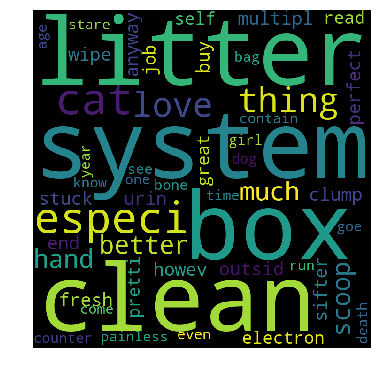

In [328]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about how the product tastes and quality

* <b>Cluster 2<b>

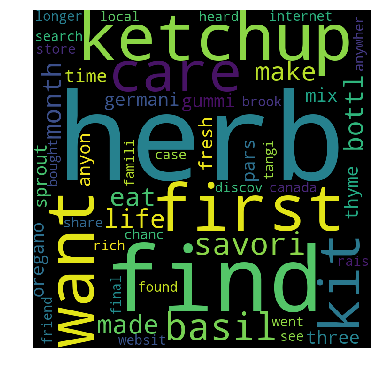

In [329]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about how the product tastes and quality.

* <b>Cluster 3<b>

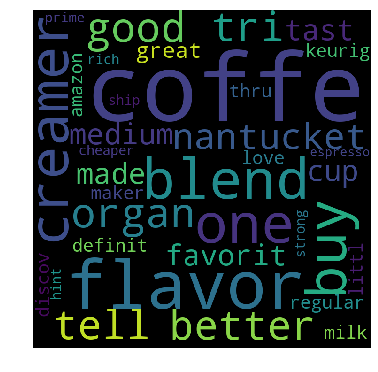

In [330]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_3) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about coffee products.

* <b>Cluster 4<b>

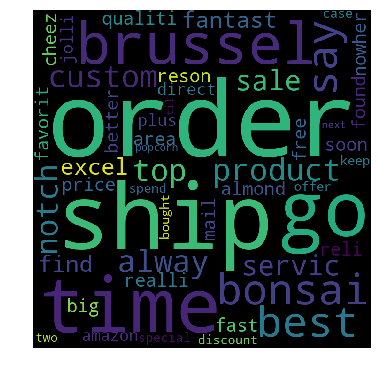

In [331]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_4) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

* <b>Cluster 5<b>

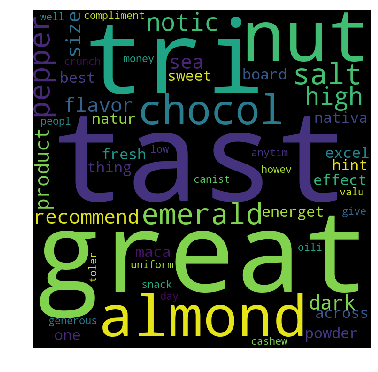

In [332]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_5) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about choco products.

* <b>Cluster 6<b>

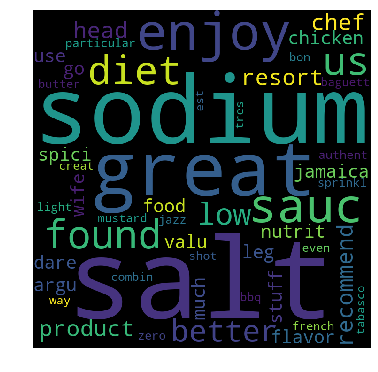

In [333]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_6) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about cooking powder products.

##### Performance Metric of K means using Avg W2V

In [334]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html

from sklearn.metrics import silhouette_score

In [335]:
score = silhouette_score(avg_w2v_train,labels)

In [336]:
score

0.08058237853777399

#### Observation:

* As per the silhouette score document if the score is nearest to the Zero. The Clusters are Overlapped. So here The Silhouette Score is 0.08. So  here the chance of clusters overlapping is high.

#### 4.6 K-Means using TFIDF W2V

In [337]:
# Hyperparameter tuning 

k = [2,3,4,5,6,8,10]

inertias=[]

for i in tqdm(k):
    
    model = KMeans(n_clusters=i,n_jobs=-1)
    model.fit(tfidf_w2v_train)
    sum_sq_values = model.inertia_
    inertias.append(sum_sq_values)


100%|██████████| 7/7 [00:20<00:00,  3.51s/it]

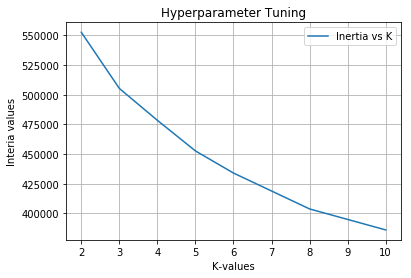

In [338]:
# plotting the k vs inertia 

plt.close()
plt.plot(k,inertias,label="Inertia vs K")
plt.grid()
plt.title("Hyperparameter Tuning")
plt.xlabel("K-values")
plt.ylabel("Interia values")
plt.legend()
plt.show()

##### Observation:

* By using the elbow method the best k (number of clusters) is 6

In [339]:
# Applying Best Hyperparameter

model= KMeans(n_clusters=6,n_jobs=-1)
model.fit(tfidf_w2v_train)
labels=model.labels_

##### Number Datapoints in Each Cluster

In [340]:
# Data points seperation as per the clusters

number_points = labels.shape[0]
print("Number of Datapoints")
print(number_points)

Number of Datapoints
50000


In [341]:
# Datapoints divided by clusters as per the label name

cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]
cluster_5=[]
cluster_6=[]

for i in range(0,number_points):
    
    if labels[i] == 0:
        cluster_1.append(i)
    if labels[i] == 1:
        cluster_2.append(i)
    if labels[i] == 2:
        cluster_3.append(i)
    if labels[i] == 3:
        cluster_4.append(i)
    if labels[i] == 4:
        cluster_5.append(i)
    if labels[i] == 5:
        cluster_6.append(i)

In [342]:
# The number of datapoints in each cluster

b=PrettyTable()

b.field_names = ["Cluster", "Number of Data Points"]

print(" The number of datapoints in each cluster")
print("="*120)

b.add_row([1,str(len(cluster_1))])
b.add_row([2,str(len(cluster_2))])
b.add_row([3,str(len(cluster_3))])
b.add_row([4,str(len(cluster_4))])
b.add_row([5,str(len(cluster_5))])
b.add_row([6,str(len(cluster_6))])
print(b)

 The number of datapoints in each cluster
+---------+-----------------------+
| Cluster | Number of Data Points |
+---------+-----------------------+
|    1    |         14585         |
|    2    |         14848         |
|    3    |          3533         |
|    4    |          3894         |
|    5    |          3131         |
|    6    |         10009         |
+---------+-----------------------+


##### Wordcloud for each cluster:

###### Cluster 1

* Getting the sample reviews in Cluster 1

In [343]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(14585,size=3)

In [344]:
rand_num = list(rand_num)

In [345]:
rand_num

[5869, 6581, 13523]

In [346]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_1[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [347]:
string_1 = " ".join(word_cloud)

In [348]:
string_1

'drank can bottl green tea discov lipton varieti not spend money over sweeten product uniqu pyramid bag get much flavor intens tea without ad sweeten must add sugar honey tast like orang flavor without doctor also like amazon great price zevia twist tast refresh flavor natur oil lemon lime realli come water drinker soda never quench thirst stuff healthi none artifici sweeten color flavor chemic regular diet soda tri believ nice light refresh carbon fruit juic someth like orangina far natur tast make sens unlik orangina juic no ad sweeten complaint ounc rather small general prefer larger drink definit not bargain drink two can time'

In [349]:
wordcloud_1 = WordCloud(width=720, height=720, max_words=50).generate(string_1)

###### Cluster 2

* Getting the sample reviews in Cluster 2

In [350]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(14848,size=3)
rand_num = list(rand_num)

In [351]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_2[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [352]:
string_2 = " ".join(word_cloud)

In [353]:
string_2

'love aero garden second crop grow seven differ kind basil seed germin within three day expect begin harvest anoth week two request addit aero garden mother day present use grow salad green take fenugreek brewer yeast capsul well drink tea day pump everi hrs hour except work hrs day pump oz everi singl time first oz time everi hrs talk major increas love pleasant tastey stevia natur sweeten also high recommend start notic littl bug fli thru home almost immedi receiv tree not make connect right away window near tree start crawl bug forc throw tree no longer tree hous hundr dead bug deal one worst purchas ever'

In [354]:
wordcloud_2 = WordCloud(width=720, height=720, max_words=50).generate(string_2)

###### Cluster 3

* Getting the sample reviews in Cluster 3

In [355]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(3533,size=3)
rand_num = list(rand_num)

In [356]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_3[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [357]:
string_3 = " ".join(word_cloud)

In [358]:
string_3

'favorit tea use make ice tea everi day great deal mani tea bag not run tea bag love tea add littl honey sit back relax slight citrus flavor find refressh want drink tradit tea one grab strong smooth no bitter metal tast use drink twine irish breakfast tea tea bag box pack one day grocer pick instead wow lucki often drink bigelow vanilla chai tea box pack black tea delici vanilla spice tradit black tea found none like better english breakfast tea'

In [359]:
wordcloud_3 = WordCloud(width=720, height=720, max_words=50).generate(string_3)

###### Cluster 4

* Getting the sample reviews in Cluster 4

In [360]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(3894,size=3)
rand_num = list(rand_num)

In [361]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_4[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [362]:
string_4 = " ".join(word_cloud)

In [363]:
string_4

'dog love edibl bone floppier brown rubber bone favorit long time floppi brown bone survi puppi teeth almost no damag white bone realli stiff hard almost plastic feel no interest age not like either ignor complet not even bother buri backyard favorit thing treat toy mayb dog like better bone great black lab diamond dog food puppi sever varieti dog start puppi food mainten lab mainten formula year old love addit make coat shini fantast product bull terrier capabl spit pill no matter insert peanut butter steak chicken hot dog name tri patient wait get pill readi gulp absolut amaz never without product'

In [364]:
wordcloud_4 = WordCloud(width=720, height=720, max_words=50).generate(string_4)

###### Cluster 5

* Getting the sample reviews in Cluster 5

In [365]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(3131,size=3)
rand_num = list(rand_num)

In [366]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_5[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [367]:
string_5 = " ".join(word_cloud)

In [368]:
string_5

'drank one commut cup morn would probabl need back caffein notch two espresso made stove top espresso maker delici almost worth get bed great robust charg morn add water prefer less strong brew sprinkl cinnamon mellow hook part daili ritual certain get well blend coffe wonder full bodi flavor top five tri dozen blend yes dozen green mountain distinguish leader k cup pack not much flavor coffe though appreci aroma green mountain coffe especi bold extra bold robust plain tast great'

In [369]:
wordcloud_5 = WordCloud(width=720, height=720, max_words=50).generate(string_5)

###### Cluster 6

* Getting the sample reviews in Cluster 6

In [370]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(10009,size=3)
rand_num = list(rand_num)

In [371]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_6[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [372]:
string_6 = " ".join(word_cloud)

In [373]:
string_6

'everybodi say uncl timmi chili best slave hour simmer right friend famili love best alway request baloney pull fantast chili trick year no kid chili around long good easi anyth els pound hamburg kidney bean dice tomato packet chili throw dice onion done shoot make night not want cook easi truth ever discontinu chili realli creek best secret whole kitchen well not rate probabl not haha use product year no bitter tast chemic use extract alo plant one drink gargl swish mouth use sinus irrig feminin use would use colon irrit oral prevent part colon cancer therapi ask health practition close theatr top could good tast good flavor book say popcorn'

In [374]:
wordcloud_6 = WordCloud(width=720, height=720, max_words=50).generate(string_6)

##### Plotting The Wordcloud 

* <b>Cluster 1<b> 

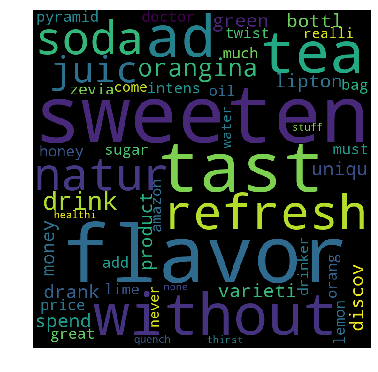

In [375]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about Green Tea like products.

* <b>Cluster 2<b>

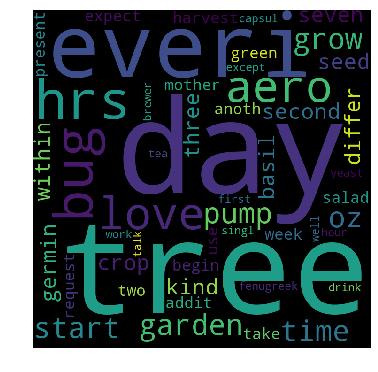

In [376]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about how the product tastes and quality

* <b>Cluster 3<b>

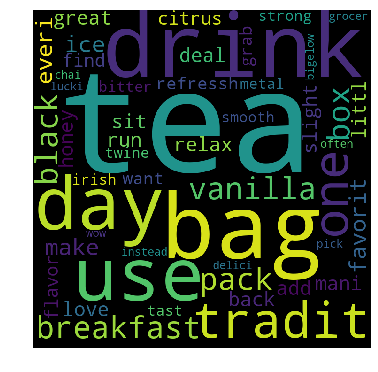

In [377]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_3) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about tea products

* <b>Cluster 4<b>

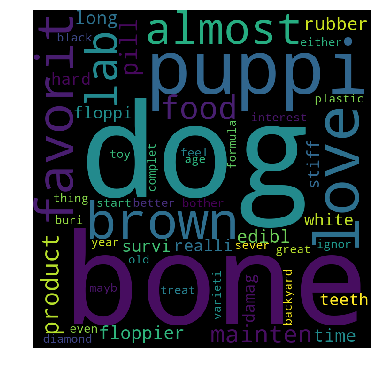

In [378]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_4) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about pet products.

* <b>Cluster 5<b>

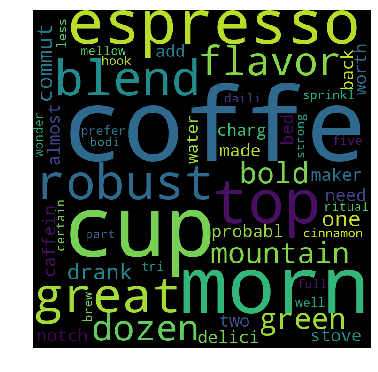

In [379]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_5) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about coffee products.

* <b>Cluster 6<b>

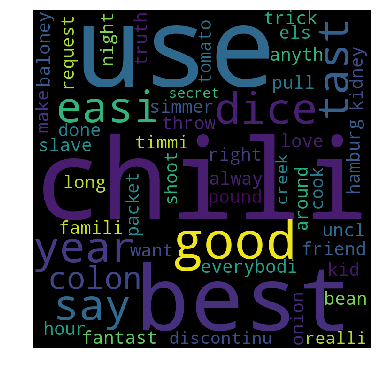

In [380]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_6) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about cooking powder products.

##### Performance Metric of K means using TFIDF W2V

In [381]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html

from sklearn.metrics import silhouette_score

In [382]:
score = silhouette_score(tfidf_w2v_train,labels)

In [383]:
score

0.11610920768204656

#### Observation:

* As per the silhouette score document if the score is nearest to the Zero. The Clusters are Overlapped. So here The Silhouette Score is 0.12. So here the chance of clusters overlapping is high.

### 5. Agglomerative Clustering

#### 5.1 Data

In [384]:
# we took the sample data size as 5k 

final_data=filter_data[:5000]
final_data.shape

(5000, 10)

In [385]:
Y=final_data.Text

#### 5.2 Featurization

##### 5.2.1 W2V

In [387]:
# References
# https://radimrehurek.com/gensim/models/word2vec.html
# https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY

from gensim.models import Word2Vec

In [388]:
list_sentences_train=[]
for i in tqdm(list(Y)):
    list_sentences_train.append(i.split())


100%|██████████| 5000/5000 [00:00<00:00, 150800.47it/s]

In [389]:
word2vec_model=Word2Vec(list_sentences_train,min_count=5,size=50,workers=4)

In [390]:
word2vec_words_train=list(word2vec_model.wv.vocab)
print(" Number of words")
print("_________________")
print(" ")
print(len(word2vec_words_train))
print("="*125)
print(" sample words")
print("_________________")
print(" ")
print(word2vec_words_train[100:150])

 Number of words
_________________
 
3966
 sample words
_________________
 
['fill', 'comedi', 'action', 'whatev', 'els', 'want', 'call', 'enjoy', 'entertain', 'hesit', 'pick', 'edit', 'guess', 'market', 'plan', 'famili', 'elimin', 'strong', 'element', 'usual', 'version', 'warn', 'uncut', 'avoid', 'apart', 'fruit', 'fli', 'hour', 'trap', 'quot', 'attract', 'mani', 'within', 'practic', 'gone', 'may', 'long', 'term', 'solut', 'crazi', 'consid', 'buy', 'caution', 'surfac', 'sticki', 'tri', 'touch', 'happen', 'say', 'name']


##### 5.2.2 Avg W2V

In [391]:
# Reference
# formula of Avg word2vec = sum of all (wi)[i=0 to n]/n

# avg word2vec on training data

avg_word2vec_train=[]
for i in list_sentences_train:
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_train.append(vector)  
avg_w2v_train1=np.asmatrix(avg_word2vec_train)
print("shape of Avg Word2vec train")
print(avg_w2v_train1.shape)

shape of Avg Word2vec train
(5000, 50)


##### 5.2.3 TFIDF W2V

In [393]:
# References
# https://stackoverflow.com/questions/21553327
# https://github.com/devBOX03


# tfidf word2vec on training data

model=TfidfVectorizer()
tfidf_w2v_model=model.fit_transform(Y)
tfidf_w2v=model.get_feature_names()
tfidf_word2vec_train=[]
row=0
for i in list_sentences_train:
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_train.append(vec)
    row=row+1
tfidf_w2v_train1=np.asmatrix(tfidf_word2vec_train)
print("Shape of TFIDF word2vec train")
print(tfidf_w2v_train1.shape)

Shape of TFIDF word2vec train
(5000, 50)


#### 5.3Agglomerative using Avg W2V

In [394]:
# References 
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

from sklearn.cluster import AgglomerativeClustering

In [396]:
# Hyperparameter tuning 

k = [2,3,4,5,6,8,10]

silhouette_score_value=[]

for i in tqdm(k):
    
    model = AgglomerativeClustering(n_clusters=i)
    model.fit(avg_w2v_train1)
    labels = model.labels_
    score = silhouette_score(avg_w2v_train1,labels)
    silhouette_score_value.append(score)


100%|██████████| 7/7 [00:14<00:00,  2.00s/it]

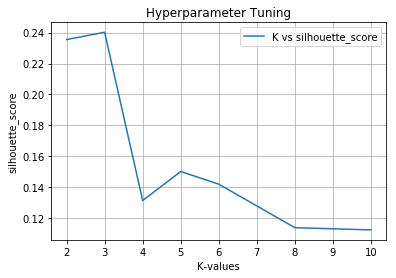

In [397]:
# plotting the k vs inertia 

plt.close()
plt.plot(k,silhouette_score_value,label="K vs silhouette_score")
plt.grid()
plt.title("Hyperparameter Tuning")
plt.xlabel("K-values")
plt.ylabel("silhouette_score")
plt.legend()
plt.show()

##### Observation:

* By using the silhouette_score value the best k (number of clusters) is 3. ( k=3, silhouette_score =0.24)

In [398]:
# Applying Best Hyperparameter

model= AgglomerativeClustering(n_clusters=3)
model.fit(avg_w2v_train1)
labels=model.labels_

##### Number Datapoints in Each Cluster

In [399]:
# Data points seperation as per the clusters

number_points = labels.shape[0]
print("Number of Datapoints")
print(number_points)

Number of Datapoints
5000


In [400]:
# Datapoints divided by clusters as per the label name

cluster_1=[]
cluster_2=[]
cluster_3=[]

for i in range(0,number_points):
    
    if labels[i] == 0:
        cluster_1.append(i)
    if labels[i] == 1:
        cluster_2.append(i)
    if labels[i] == 2:
        cluster_3.append(i)

In [401]:
# The number of datapoints in each cluster

d=PrettyTable()

d.field_names = ["Cluster", "Number of Data Points"]

print(" The number of datapoints in each cluster")
print("="*120)

d.add_row([1,str(len(cluster_1))])
d.add_row([2,str(len(cluster_2))])
d.add_row([3,str(len(cluster_3))])
print(d)

 The number of datapoints in each cluster
+---------+-----------------------+
| Cluster | Number of Data Points |
+---------+-----------------------+
|    1    |          2559         |
|    2    |          1617         |
|    3    |          824          |
+---------+-----------------------+


##### Wordcloud for each cluster:

###### Cluster 1

* Getting the sample reviews in Cluster 1

In [402]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(2559,size=3)

In [403]:
rand_num = list(rand_num)

In [404]:
rand_num

[167, 1816, 1146]

In [405]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_1[i])
    
for i in index:
    
    word_cloud.append(Y.values[i])

In [406]:
string_1 = " ".join(word_cloud)

In [407]:
string_1

'worst dri mango product tast threw away whole bag ingredi not read use sugar preserv thought natur no sugar saw think use bunch sugar also use preserv well miss ingredi still ok tast good product also use sugar preserv howev worst dri mango ever neither pleas nor health alreadi lost money spend not want bother mouth nor health worst threw away whole bag decis no attach recommend philipin import dire mango product mango fine refer bought organ natur dri mango quit differ philipin product real dri somewhat hard rather soft chewi like philipin product use no sugar no preserv love flavor unlik sport drink half way canist not tire flavor day day drink stuff day week mix well water provid adequa nutrit endur workout slight odd aftertast bit chalki not tri powder drink not sure normal product type specif product either way like stuff would purchas ginger chew amaz thing ginger help nausea sort includ caus chemo motion sick heartburn heard even menstrual cramp ailment fresh ginger strong slig

In [408]:
wordcloud_1 = WordCloud(width=720, height=720, max_words=50).generate(string_1)

###### Cluster 2

* Getting the sample reviews in Cluster 2

In [409]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(1617,size=3)
rand_num = list(rand_num)

In [410]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_2[i])
    
for i in index:
    
    word_cloud.append(Y.values[i])

In [411]:
string_2 = " ".join(word_cloud)

In [412]:
string_2

'would high recommend chill freezer first great cold treat not melt not eat fast enough big fan find cheap long eat within day moist chewi normal buy bagel bagel store short fund want yummi snack aorund hous feed friend good call also good cream chees cours develop sugarfre recip find egg invalu ad extra liquid exist recip date not disappoint bake result yet would purchas'

In [413]:
wordcloud_2 = WordCloud(width=720, height=720, max_words=50).generate(string_2)

###### Cluster 3

* Getting the sample reviews in Cluster 3

In [414]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(824,size=3)
rand_num = list(rand_num)

In [415]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_3[i])
    
for i in index:
    
    word_cloud.append(Y.values[i])

In [416]:
string_3 = " ".join(word_cloud)

In [417]:
string_3

'tea not tast like expect long time use loos leaf white tea jasmin enjoyingtea com realli happi want portabl tea bag offer enjoyingtea not product offer purchas republ tea asian jasmin white tea cost plus world market open canist not smell like jasmin rancid candi smell jasmin usual sweet floral scent tast marri well green white tea tea not smell tast like almost smell like mix orang flavor white tea offer use sparklett bottl water not fan tap water tast tea even better water no light tea tast like usual white tea tea turn golden yellow like tang tast not tast like jasmin tap water one could imagin tast would much wors least live read elsewher tea use tea bag usual lower grade usual tast way resort buy box tea filter bag make tea bag loos leaf tea alreadi bottom line familair tast white tea tea bag dissappoint tri loos leaf white tea jasmin instead tea provid luscious refresh break daili grind help relax well got great lemon tast not overpow let steep three minut bound enjoy much bag c

In [418]:
wordcloud_3 = WordCloud(width=720, height=720, max_words=50).generate(string_3)

##### Plotting The Wordcloud 

* <b>Cluster 1<b> 

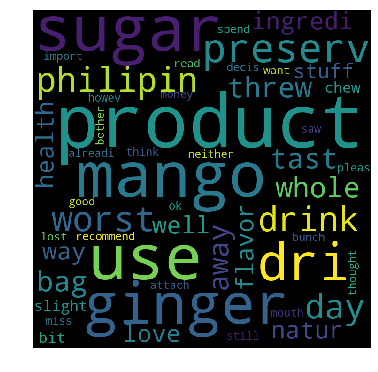

In [419]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about Negative reviews of the product.

* <b>Cluster 2<b>

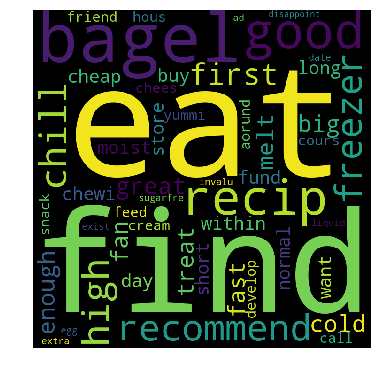

In [420]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about Positive reviews of the products.

* <b>Cluster 3<b>

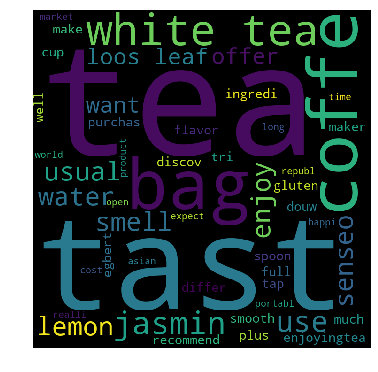

In [421]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_3) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about tea products.

##### Performance Metric of Agglomerative using Avg W2V

In [422]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html

from sklearn.metrics import silhouette_score

In [423]:
score = silhouette_score(avg_w2v_train1,labels)

In [424]:
score

0.24021730070249372

#### Observation:

* As per the silhouette score document if the score is nearest to the Zero. The Clusters are Overlapped. So here The Silhouette Score is 0.24. So  here the chance of clusters overlapping is high.

#### 5.4 Agglomerative using TFIDF W2V

In [425]:
# Hyperparameter tuning 

k = [2,3,4,5,6,8,10]

silhouette_score_value=[]

for i in tqdm(k):
    
    model = AgglomerativeClustering(n_clusters=i)
    model.fit(tfidf_w2v_train1)
    labels = model.labels_
    score = silhouette_score(tfidf_w2v_train1,labels)
    silhouette_score_value.append(score)


100%|██████████| 7/7 [00:14<00:00,  2.06s/it]

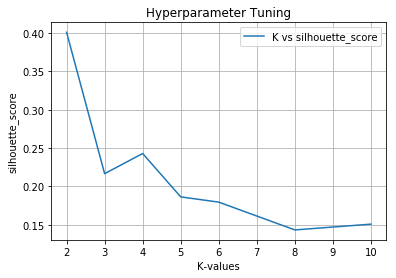

In [426]:
# plotting the k vs inertia 

plt.close()
plt.plot(k,silhouette_score_value,label="K vs silhouette_score")
plt.grid()
plt.title("Hyperparameter Tuning")
plt.xlabel("K-values")
plt.ylabel("silhouette_score")
plt.legend()
plt.show()

##### Observation:

* By using the silhouette_score value the best k (number of clusters) is 2. ( k=2, silhouette_score =0.40)

In [427]:
# Applying Best Hyperparameter

model= AgglomerativeClustering(n_clusters=2)
model.fit(tfidf_w2v_train1)
labels=model.labels_

##### Number Datapoints in Each Cluster

In [428]:
# Data points seperation as per the clusters

number_points = labels.shape[0]
print("Number of Datapoints")
print(number_points)

Number of Datapoints
5000


In [429]:
# Datapoints divided by clusters as per the label name

cluster_1=[]
cluster_2=[]

for i in range(0,number_points):
    
    if labels[i] == 0:
        cluster_1.append(i)
    if labels[i] == 1:
        cluster_2.append(i)

In [431]:
# The number of datapoints in each cluster

e=PrettyTable()

e.field_names = ["Cluster", "Number of Data Points"]

print(" The number of datapoints in each cluster")
print("="*120)

e.add_row([1,str(len(cluster_1))])
e.add_row([2,str(len(cluster_2))])
print(e)

 The number of datapoints in each cluster
+---------+-----------------------+
| Cluster | Number of Data Points |
+---------+-----------------------+
|    1    |          4184         |
|    2    |          816          |
+---------+-----------------------+


##### Wordcloud for each cluster:

###### Cluster 1

* Getting the sample reviews in Cluster 1

In [432]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(4184,size=3)

In [433]:
rand_num = list(rand_num)

In [434]:
rand_num

[720, 324, 2822]

In [435]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_1[i])
    
for i in index:
    
    word_cloud.append(Y.values[i])

In [436]:
string_1 = " ".join(word_cloud)

In [437]:
string_1

'love tast caramel crisp crunch thin cooki not fill no better altern eat day bite touch cranberri sooth flavor aroma appl reminisc cranberri cocktail serv cold great flavor ice tea hot flake cinnamon drift la la land consum near zero calori appl pie stuff good product excel dog chew stick dog absolut love not swell throat like rawhid sometim price amazon much better dog show pet shop discount catalogu still littl expens costco came within day order'

In [438]:
wordcloud_1 = WordCloud(width=720, height=720, max_words=50).generate(string_1)

###### Cluster 2

* Getting the sample reviews in Cluster 2

In [439]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(816,size=3)
rand_num = list(rand_num)

In [440]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_2[i])
    
for i in index:
    
    word_cloud.append(Y.values[i])

In [441]:
string_2 = " ".join(word_cloud)

In [442]:
string_2

'receiv jar instant espresso gift mother law quit insult first never use instant coffe kind could not figur gave past weekend coffe bean must coffe morn made wow awesom fact drink mug right right review love howev make latt fashion also ad hot chocol mocha latt definit look neighborhood store not find get amazon definit great buy kcup strong enough tast largest set say want someth coffe water reach dark magic cheer senseo machin frank coffe lover not live starbuck need one pod use rich flavour design work machin'

In [443]:
wordcloud_2 = WordCloud(width=720, height=720, max_words=50).generate(string_2)

##### Plotting The Wordcloud 

* <b>Cluster 1<b> 

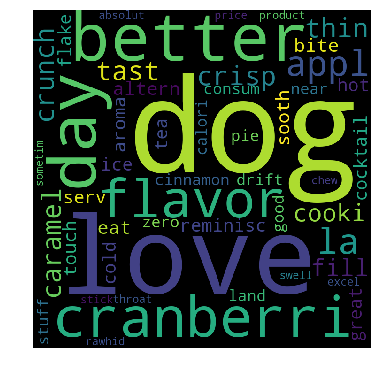

In [444]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about how the product tastes and quality

* <b>Cluster 2<b>

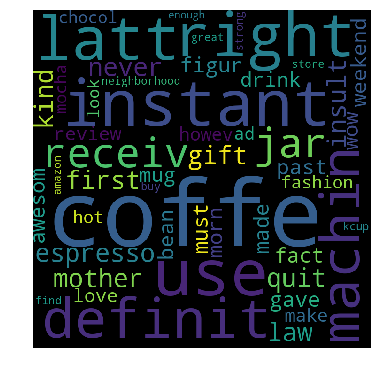

In [445]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about how the product tastes and quality

##### Performance Metric of Agglomerative using TFIDF W2V

In [446]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html

from sklearn.metrics import silhouette_score

In [447]:
score = silhouette_score(tfidf_w2v_train1,labels)

In [448]:
score

0.401189873208517

#### Observation:

* As per the silhouette score document if the score is nearest to the Zero. The Clusters are Overlapped. So here The Silhouette Score is 0.40. So here the chance of clusters overlapping is high.

### 6. DBSCAN Clustering

#### 6.1 DBSCAN using Avg W2V

In [450]:
# References 
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN

from sklearn.cluster import DBSCAN

In [473]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

# Hyperparameter tuning

e=[0.3,0.5,0.7,0.9,1.0]
min_sample=[100,120,140,160,200]
silhouette_score_value=[]

for i,j in tqdm(zip(e,min_sample)):

    model= DBSCAN(eps=i,min_samples=j)
    model.fit(avg_w2v_train1)
    labels=model.labels_
    score=silhouette_score(avg_w2v_train1,labels)
    silhouette_score_value.append(score)


0it [00:00, ?it/s]
1it [00:02,  2.89s/it]
2it [00:06,  3.16s/it]
3it [00:11,  3.60s/it]
4it [00:16,  4.04s/it]
5it [00:22,  4.66s/it]

In [475]:
# References
# https://pythonprogramming.net/matplotlib-3d-scatterplot-tutorial/

from mpl_toolkits.mplot3d import Axes3D

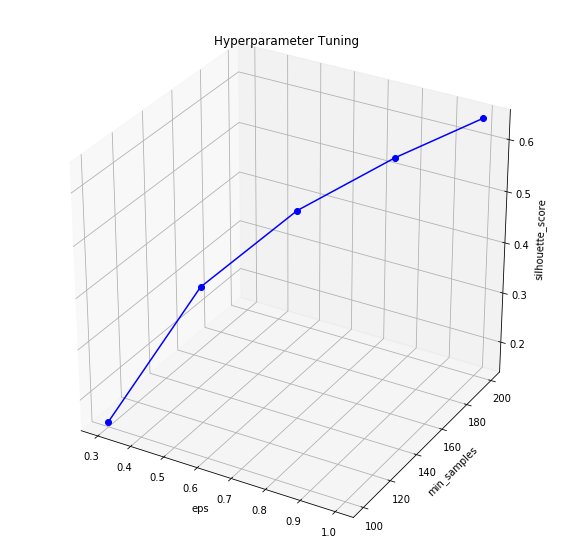

In [477]:
# Hyperparameter Tuning

plt.close()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(e,min_sample,silhouette_score_value,c='b', marker='o')
ax.set_xlabel('eps')
ax.set_ylabel('min_samples')
ax.set_zlabel('silhouette_score')
plt.title("Hyperparameter Tuning")
plt.show()

##### Observation:

* By using the silhouette_score value the best eps=1.0 and best min_samples=200

In [478]:
# Applying Best Hyperparameter

model= DBSCAN(eps=1.0,min_samples=200)
model.fit(avg_w2v_train1)
labels=model.labels_

In [479]:
set(labels)

{-1, 0}

##### Observation:

* There is only two sets one is one cluster and another one is noise points.

##### Number Datapoints in Each Cluster

In [480]:
# Data points seperation as per the clusters

number_points = labels.shape[0]
print("Number of Datapoints")
print(number_points)

Number of Datapoints
5000


In [481]:
# Datapoints divided by clusters as per the label name

cluster_1=[]
cluster_2=[]

for i in range(0,number_points):
    
    if labels[i] == 0:
        cluster_1.append(i)
    if labels[i] == -1:
        cluster_2.append(i)

In [482]:
# The number of datapoints in each cluster

d=PrettyTable()

d.field_names = ["Cluster", "Number of Data Points"]

print(" The number of datapoints in each cluster")
print("="*120)

d.add_row([1,str(len(cluster_1))])
d.add_row([-1,str(len(cluster_2))])
print(d)

 The number of datapoints in each cluster
+---------+-----------------------+
| Cluster | Number of Data Points |
+---------+-----------------------+
|    1    |          4990         |
|    -1   |           10          |
+---------+-----------------------+


##### Wordcloud for each cluster:

###### Cluster 1

* Getting the sample reviews in Cluster 1

In [483]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(4990,size=3)

In [484]:
rand_num = list(rand_num)

In [485]:
rand_num

[224, 135, 750]

In [486]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_1[i])
    
for i in index:
    
    word_cloud.append(Y.values[i])

In [487]:
string_1 = " ".join(word_cloud)

In [488]:
string_1

'sportea answer healthi daili drink thirst quench great tast drink tea drink day not get advers effect get soda regular caffin load ice tea zero calori littl caffin zero calori lot electrolyt vitamin c zero calori sweet refresh hint citrus flavor zero calori drink gallon day big fan wish would bottl sportea junki tip take larg cup like big gulp cup put sportea ice tea bag bottom cover ice add water top let sportea steep min readi guilt free sip day yum tapatio salsa picant one favorit hot sauc flavor smoki complex tabasco popular hot sauc although goe perfect almost kind mexican southwestern food also great compliment varieti dish includ spaghetti soup addit sodium content relat low per teaspoon mani compar brand make excel low sodium way add flavor food high recommend smoke bomb spring load spike trap gave mole invas call extermin use trap not miss caught six two day found trap line order two month later saw anoth mole tunnel next day care set trap power way extermin get mole'

In [489]:
wordcloud_1 = WordCloud(width=720, height=720, max_words=50).generate(string_1)

###### Cluster 2

* Getting the sample reviews in Cluster 2

In [490]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(10,size=3)
rand_num = list(rand_num)

In [491]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_2[i])
    
for i in index:
    
    word_cloud.append(Y.values[i])

In [492]:
string_2 = " ".join(word_cloud)

In [493]:
string_2

'stuff hot great flavor hot sauc collector differ hot sauc absolut favorit stuff hot great flavor hot sauc collector differ hot sauc absolut favorit buy local store great product'

In [494]:
wordcloud_2 = WordCloud(width=720, height=720, max_words=50).generate(string_2)

##### Plotting The Wordcloud 

* <b>Cluster 1<b> 

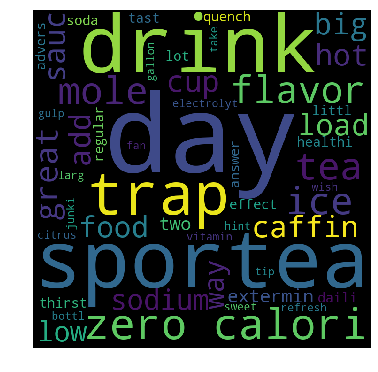

In [495]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about how the product tastes and quality

* <b>Cluster 2<b>

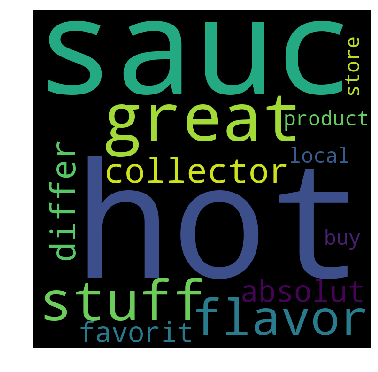

In [496]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* These are all noisy points of the cluster.

##### Performance Metric of DBSCAN using Avg W2V

In [497]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html

from sklearn.metrics import silhouette_score

In [498]:
score = silhouette_score(avg_w2v_train1,labels)

In [499]:
score

0.6463535708832251

#### Observation:

* As per the silhouette score document if the score is nearest to One. The Clusters are less Overlapped. So here The Silhouette Score is 0.64.

#### 6.2 DBSCAN using TFIDF W2V

In [500]:
# References 
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN

from sklearn.cluster import DBSCAN

In [503]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

# Hyperparameter tuning

e=[0.3,0.5,0.7,0.9,1.0]
min_sample=[100,120,140,160,200]
silhouette_score_value=[]

for i,j in tqdm(zip(e,min_sample)):

    model= DBSCAN(eps=i,min_samples=j)
    model.fit(tfidf_w2v_train1)
    labels=model.labels_
    score=silhouette_score(tfidf_w2v_train1,labels)
    silhouette_score_value.append(score)


0it [00:00, ?it/s]
1it [00:02,  2.52s/it]
2it [00:05,  2.77s/it]
3it [00:10,  3.19s/it]
4it [00:14,  3.59s/it]
5it [00:19,  3.93s/it]

In [504]:
# References
# https://pythonprogramming.net/matplotlib-3d-scatterplot-tutorial/

from mpl_toolkits.mplot3d import Axes3D

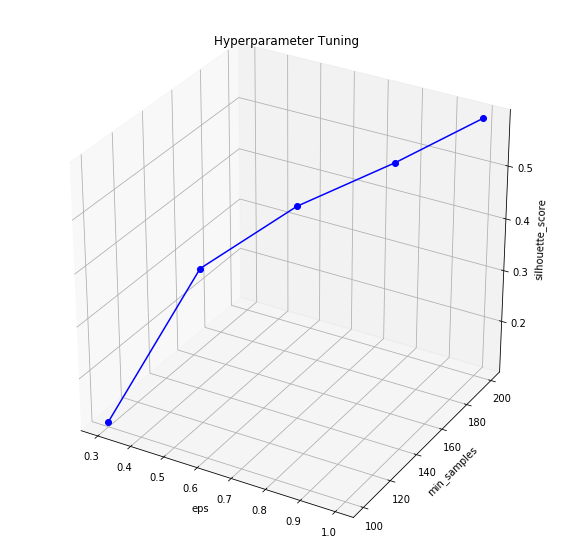

In [505]:
# Hyperparameter Tuning

plt.close()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(e,min_sample,silhouette_score_value,c='b', marker='o')
ax.set_xlabel('eps')
ax.set_ylabel('min_samples')
ax.set_zlabel('silhouette_score')
plt.title("Hyperparameter Tuning")
plt.show()

##### Observation:

* By using the silhouette_score value the best eps=1.0 and best min_samples=200

In [506]:
# Applying Best Hyperparameter

model= DBSCAN(eps=1.0,min_samples=200)
model.fit(tfidf_w2v_train1)
labels=model.labels_

In [507]:
set(labels)

{-1, 0}

##### Observation:

* There is only two sets one is one cluster and another one is noise points.

##### Number Datapoints in Each Cluster

In [508]:
# Data points seperation as per the clusters

number_points = labels.shape[0]
print("Number of Datapoints")
print(number_points)

Number of Datapoints
5000


In [509]:
# Datapoints divided by clusters as per the label name

cluster_1=[]
cluster_2=[]

for i in range(0,number_points):
    
    if labels[i] == 0:
        cluster_1.append(i)
    if labels[i] == -1:
        cluster_2.append(i)

In [510]:
# The number of datapoints in each cluster

d=PrettyTable()

d.field_names = ["Cluster", "Number of Data Points"]

print(" The number of datapoints in each cluster")
print("="*120)

d.add_row([1,str(len(cluster_1))])
d.add_row([-1,str(len(cluster_2))])
print(d)

 The number of datapoints in each cluster
+---------+-----------------------+
| Cluster | Number of Data Points |
+---------+-----------------------+
|    1    |          4934         |
|    -1   |           66          |
+---------+-----------------------+


##### Wordcloud for each cluster:

###### Cluster 1

* Getting the sample reviews in Cluster 1

In [511]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(4934,size=3)

In [512]:
rand_num = list(rand_num)

In [513]:
rand_num

[17, 2574, 1965]

In [514]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_1[i])
    
for i in index:
    
    word_cloud.append(Y.values[i])

In [515]:
string_1 = " ".join(word_cloud)

In [516]:
string_1

'beetlejuic awe inspir wonder amus comed romp explor incred possibl life boundari absurd tell tale recent dead marri coupl sudden get led chaotic world supernatur adam barbara maitland alec baldwin geena davi discov mani conflict rather human imperfect haunt live live also plagu afterlif well unlik film project seem blind assign dispassion filmmak commerci reason beetlejuic plot bizarr subject matter remark complement burton unusu macabr artist sensibl extraordinarili well creat unbeliev brilliant guidanc imagin film director tim burton pee wee big adventur batman ed wood sleepi hollow film uniqu creativ landscap culmin essenti abund ironi outlandish yet human behavior grace bodi burton work augment devious energet perform glenn shadix jeffrey jone winona ryder catherin hara geena davi alec baldwin film bustl uninhibit brilliant hilar persist push film level almost affabl euphoria pair ingeni screenplay tour de forc perform michael keaton beetlejuic film transform exuber jovial exercis

In [517]:
wordcloud_1 = WordCloud(width=720, height=720, max_words=50).generate(string_1)

###### Cluster 2

* Getting the sample reviews in Cluster 2

In [518]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(66,size=3)
rand_num = list(rand_num)

In [519]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_2[i])
    
for i in index:
    
    word_cloud.append(Y.values[i])

In [520]:
string_2 = " ".join(word_cloud)

In [521]:
string_2

'dog akita hate take pill not pill pocket dog pill pocket cat click no button review help read comment valu dog take small pill andi take pill hypothyroid past year pill tini wrap meat chees never work simpli ate around pill spit year way could get andi take pill liter shove throat hand small enough mouth big enough thank trust dog one day vet notic packag someth call pill pocket two kind one dog one cat came flavor andi would like dog pill pocket came differ size small larg cat pill pocket came one size small look packag care notic packag cat pill pocket packag small dog pill pocket yet packag small dog cost packag cat huh amazon com price quantiti differ look andi tini thyroid pill look pill pocket pictur packag decid might well save buck buy kitti pill pocket hey andi not know eat someth intend cat happi decis ever bought salmon chicken flavor pill pocket cat andi like pocket perfect size big enough thyroid pill date gulp everi one beg anoth like fact get packag would bought pill po

In [522]:
wordcloud_2 = WordCloud(width=720, height=720, max_words=50).generate(string_2)

##### Plotting The Wordcloud 

* <b>Cluster 1<b> 

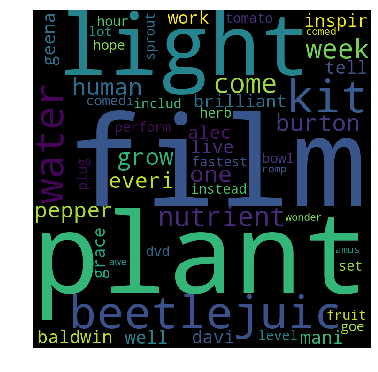

In [523]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about how the product tastes and quality

* <b>Cluster 2<b>

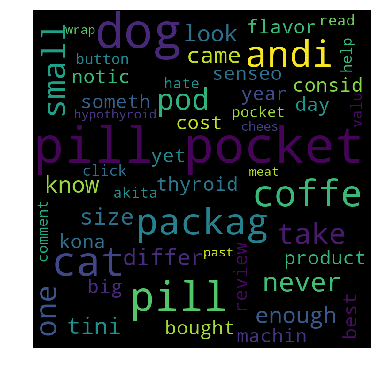

In [524]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* These are all noisy points of the cluster.

##### Performance Metric of DBSCAN using TFIDF W2V

In [525]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html

from sklearn.metrics import silhouette_score

In [526]:
score = silhouette_score(tfidf_w2v_train1,labels)

In [527]:
score

0.5946827234675885

#### Observation:

* As per the silhouette score document if the score is nearest to One. The Clusters are less Overlapped. So here The Silhouette Score is 0.59.

### 7. Conclusion:

#### Performance of the model.

* Here we choose silhouette_score as the performance metric. As per the silhouette_score, Best value is 1. Worst value is -1. if the value is near to the zero the clusters are overlapped.

In [531]:
a=PrettyTable()

a.field_names = ["Model", "Vectorizer", "Silhouette_score"]

a.add_row(["K- Means","BoW",0.16])                   
a.add_row(["K- Means","TFIDF",0.02])
a.add_row(["K- Means","Avg W2V",0.08])
a.add_row(["K- Means","Tfidf W2V",0.12])
a.add_row(["Agglomerative","Avg W2V",0.24])
a.add_row(["Agglomerative","Tfidf W2V",0.40])
a.add_row(["DBSCAN","Avg W2V",0.64])
a.add_row(["DBSCAN","Tfidf W2V",0.59])

print(a)


+---------------+------------+------------------+
|     Model     | Vectorizer | Silhouette_score |
+---------------+------------+------------------+
|    K- Means   |    BoW     |       0.16       |
|    K- Means   |   TFIDF    |       0.02       |
|    K- Means   |  Avg W2V   |       0.08       |
|    K- Means   | Tfidf W2V  |       0.12       |
| Agglomerative |  Avg W2V   |       0.24       |
| Agglomerative | Tfidf W2V  |       0.4        |
|     DBSCAN    |  Avg W2V   |       0.64       |
|     DBSCAN    | Tfidf W2V  |       0.59       |
+---------------+------------+------------------+


#### 1. K-Means Clustering:

##### Data Cleaning ,Preprocessing and splitting:

* In the Data Cleaning process, we clean the duplicate datapoints and unconditioning data points. After the data cleaning process we get 364171 data points and sort based on timestamp.
* Then select the Review Text Feature as a important feature, then do data preprocessing on all the data points.
* Then select top 50k sample data points for further process.

##### Featurization:

* Then apply the data points on BOW,TFIDF,Avg W2V and TFIDF W2V for converting text to vector.

##### K-means model:

* Then apply these featurization vector on K - means model.Best number of clusters are find out by using elbow method.

##### Wordcloud:

* Then plot the wordcloud for each cluster of the model.

#### 2. Agglomerative Clustering:

##### Data Cleaning ,Preprocessing and splitting:

* In the Data Cleaning process, we clean the duplicate datapoints and unconditioning data points. After the data cleaning process we get 364171 data points and sort based on timestamp.
* Then select the Review Text Feature as a important feature, then do data preprocessing on all the data points.
* Then select top 5k sample data points for further process.

##### Featurization:

* Then apply the data points on Avg W2V and TFIDF W2V for converting text to vector.

##### Agglomerative model:

* Then apply these featurization vector on Agglomerative model.Best number of clusters are find out by using elbow method.

##### Wordcloud:

* Then plot the wordcloud for each cluster of the model.

#### 3. DBSCAN Clustering:

##### Data Cleaning ,Preprocessing and splitting:

* In the Data Cleaning process, we clean the duplicate datapoints and unconditioning data points. After the data cleaning process we get 364171 data points and sort based on timestamp.
* Then select the Review Text Feature as a important feature, then do data preprocessing on all the data points.
* Then select top 5k sample data points for further process.

##### Featurization:

* Then apply the data points on Avg W2V and TFIDF W2V for converting text to vector.

##### Agglomerative model:

* Then apply these featurization vector on DBSCAN model.Best Hyperparameters (eps, min_samples) are find out by using elbow method.

##### Wordcloud:

* Then plot the wordcloud for each cluster of the model.